In [2]:
#Step 0. 필요한 모듈과 라이브러리를 로딩합니다.
import sys # 시스템
import os  # 시스템

import pandas as pd  # 판다스 : 데이터분석 라이브러리
import numpy as np   # 넘파이 : 숫자, 행렬 데이터 라이브러리

import chromedriver_autoinstaller
import selenium
from selenium.webdriver.common.by import By
from selenium import webdriver   # 웹 브라우저 자동화
import time    # 서버와 통신할 때 중간중간 시간 지연. 보통은 1초
from tqdm import tqdm   # for문 돌릴 때 진행상황을 %게이지로 알려준다.
from datetime import datetime

# 워닝 무시
import warnings
warnings.filterwarnings('ignore')

In [13]:
import seaborn as sns      
import matplotlib.pyplot as plt

In [6]:
df_total = pd.read_csv('한우세트_최종데이터.csv')

In [7]:
# 1. '주문날짜' 컬럼을 판다스의 datetime 형식으로 강제 변환합니다.
# errors='coerce' 옵션을 넣으면 날짜가 아닌 글자(평일 오후...)는 모두 NaN(NaT)으로 변합니다.
df_total['주문날짜'] = pd.to_datetime(df_total['주문날짜'], errors='coerce')

# 2. 날짜만 남기기 (00:00:00 제거)
df_total['주문날짜'] = df_total['주문날짜'].dt.date

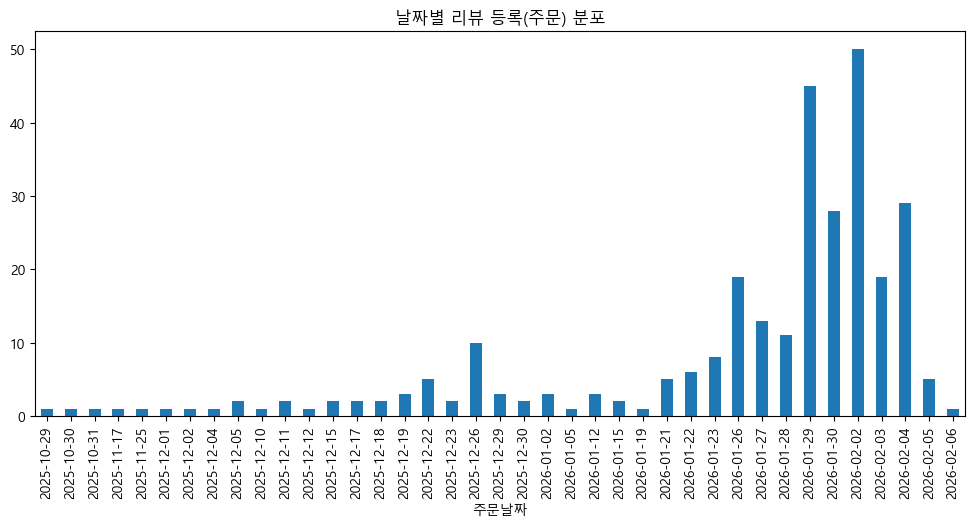

In [8]:
import matplotlib.pyplot as plt
import platform
# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 기호(-) 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 날짜가 None인 데이터는 제외하고 히스토그램 그리기
df_total['주문날짜'].dropna().value_counts().sort_index().plot(kind='bar', figsize=(12, 5))
plt.title("날짜별 리뷰 등록(주문) 분포")
plt.show()

In [9]:
df_total['포장방식'].value_counts()

포장방식
기본포장      260
고급선물포장     99
보자기포장      41
Name: count, dtype: int64

In [10]:
df_total['상품명'].value_counts()

상품명
한라명작     137
백두명작     125
천하명작      56
꽃꽃명작      52
천하특작      23
엄마네특작      7
Name: count, dtype: int64

In [11]:
df_total['별점'].value_counts()

별점
5    363
4     30
3      6
1      1
Name: count, dtype: int64

# 날짜별 주문 수 (리뷰 수)

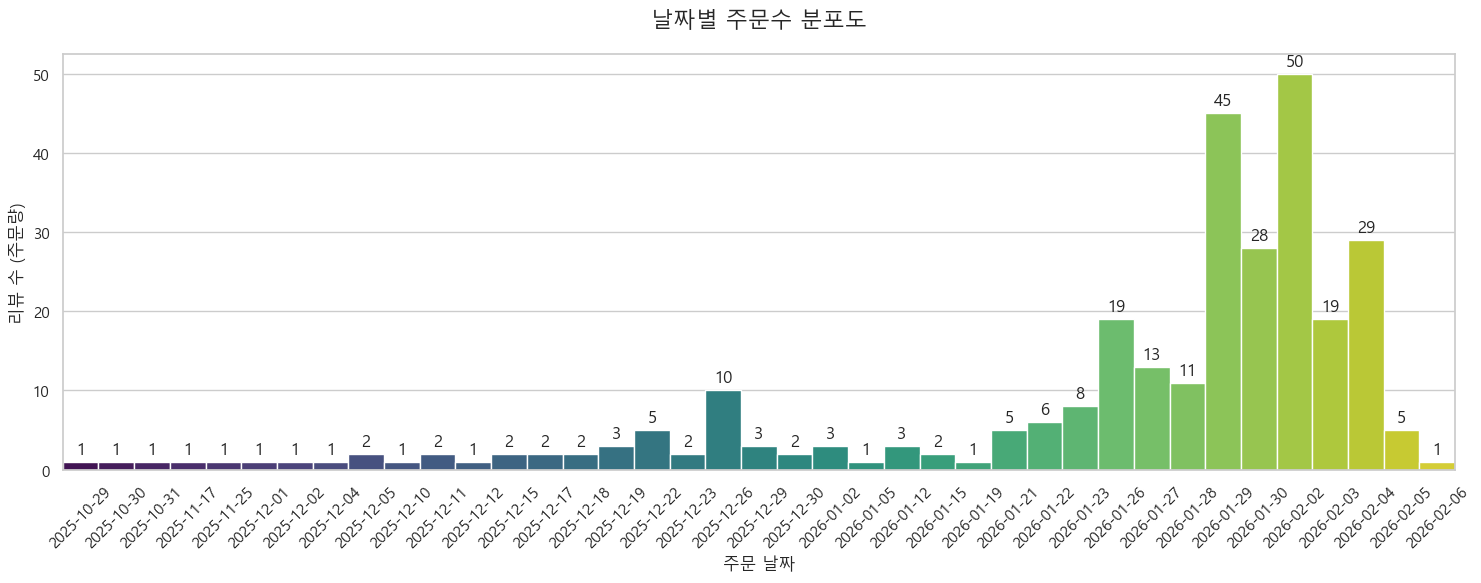

In [72]:
# 1. 데이터 준비 (날짜 데이터만 따로 추출하여 정렬)
# 에러 방지를 위해 날짜가 있는 데이터만 필터링합니다.
plot_data = df_total['주문날짜'].dropna().sort_values()

# 2. 그래프 스타일 설정
sns.set_theme(style="whitegrid", font="Malgun Gothic") # 한글 폰트 적용
plt.figure(figsize=(15, 6))

# 3. Seaborn countplot 그리기
# palette를 사용해 색상을 예쁘게 입힐 수 있습니다.
ax = sns.countplot(x=plot_data, palette="viridis", width=1.0, edgecolor="white")

# 4. 그래프 디테일 설정
plt.title("날짜별 주문수 분포도", fontsize=16, pad=20)
plt.xlabel("주문 날짜", fontsize=12)
plt.ylabel("리뷰 수 (주문량)", fontsize=12)

# X축 날짜 글자가 겹치지 않게 회전
plt.xticks(rotation=45)

# 막대 위에 숫자 표시하기 (선택 사항)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.savefig('날짜별 주문수 분포도.png', dpi=300, bbox_inches='tight')
plt.show()

# 상품 별 만족도 비교 (별점 기준)

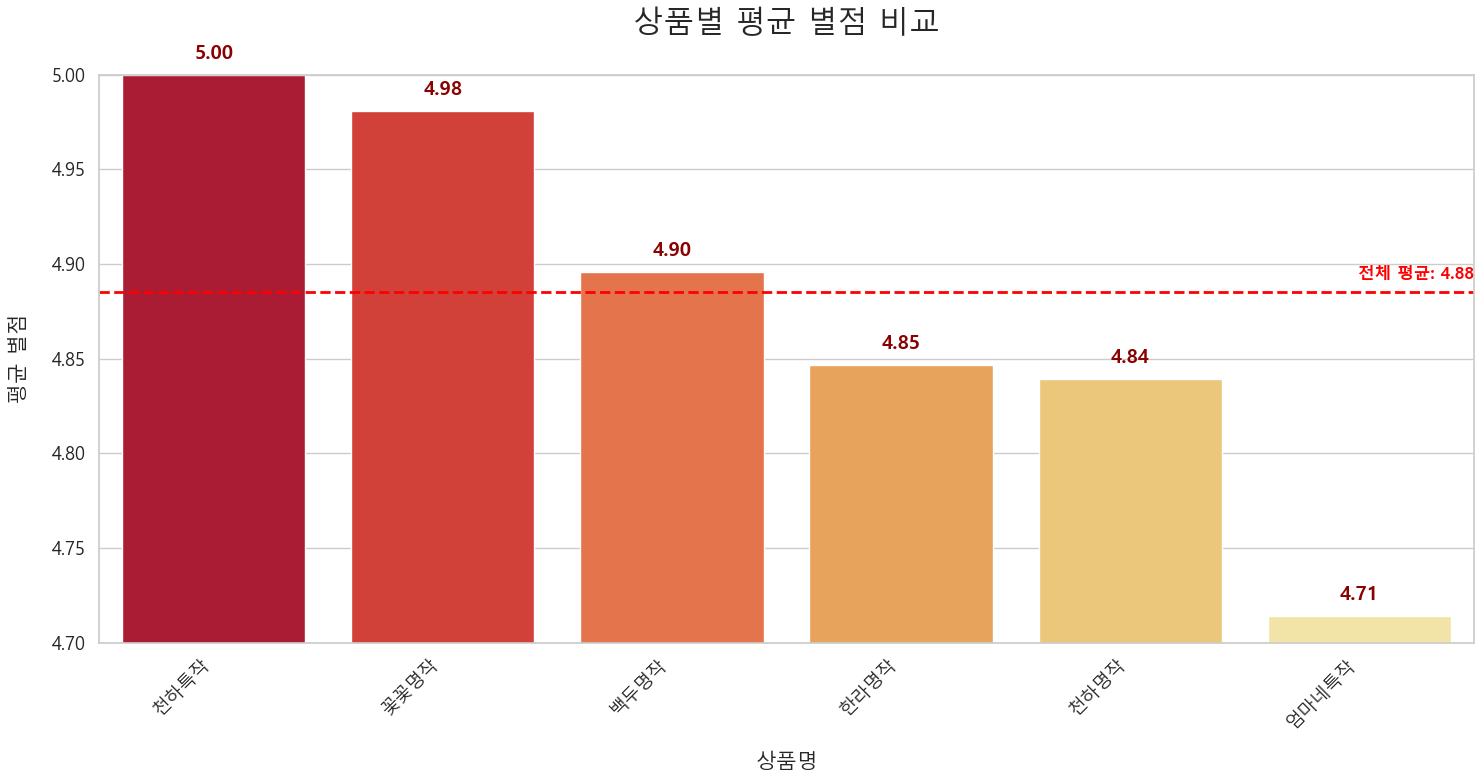

In [75]:
# 1. 전체 평균 계산
total_mean = df_total['별점'].mean()

# ... (기존 1~3번 코드 동일) ...
product_stats = df_total.groupby('상품명')['별점'].agg(['mean', 'count']).reset_index()
product_stats = product_stats.sort_values(by='mean', ascending=False)

plt.figure(figsize=(15, 8))
sns.set_theme(style="whitegrid", font="Malgun Gothic")
ax = sns.barplot(data=product_stats, x='상품명', y='mean', palette='YlOrRd_r')

# --- 새로 추가된 수평선 코드 ---
plt.axhline(total_mean, color='red', linestyle='--', linewidth=2, label=f'전체 평균: {total_mean:.2f}')
plt.text(len(product_stats)-0.5, total_mean + 0.005, f'전체 평균: {total_mean:.2f}', 
         color='red', fontweight='bold', va='bottom', ha='right')
# ------------------------------

# 4. Y축 범위 제한
plt.ylim(4.7, 5.0)

# 5. 막대 위에 점수 텍스트 표시 (fontsize를 14로 상향)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 15), # 텍스트가 커졌으므로 간격을 조금 더 띄움
                textcoords='offset points',
                fontsize=14,    # << 여기를 조절하세요 (기존 11)
                fontweight='bold',
                color='darkred') # 색상도 살짝 진하게 변경

# 6. X축, Y축 라벨 및 타이틀 설정
plt.title('상품별 평균 별점 비교', fontsize=22, pad=30) # 타이틀 크게

# X축 상품명 폰트 크기 조절
plt.xticks(rotation=45, ha='right', fontsize=13) # << fontsize 추가

# Y축 숫자 폰트 크기 조절
plt.yticks(fontsize=13)

# 축 이름(Label) 크기 조절
plt.xlabel('상품명', fontsize=15, labelpad=15)
plt.ylabel('평균 별점', fontsize=15, labelpad=15)

plt.tight_layout()
plt.savefig('상품별_평균별점.png', dpi=300, bbox_inches='tight')
plt.show()

# 어떤 상품이 가장 인기가 많을까?

In [26]:
df_total.head()

,주문날짜,별점,포장방식,상품명,후기
0,NaT,5,기본포장,백두명작,차돌박이 졸라 마싯음꾸어서\n라면이랑 먹으니까 죽는줄알았어여
1,2026-02-02,5,보자기포장,백두명작,선물 받은 분들이 너무 이쁘다고 만족해했어요
2,2026-02-03,5,고급선물포장,천하명작,배송도 빠르고 아주 만족합니다~^^
3,2026-02-04,5,기본포장,백두명작,작년 명절에도 주문해서 선물드리고 만족해서 올해도 주문했어요! 고기 질도 신선하고 ...
4,2026-02-02,5,기본포장,한라명작,맛있어요 또 구매하겠습니다


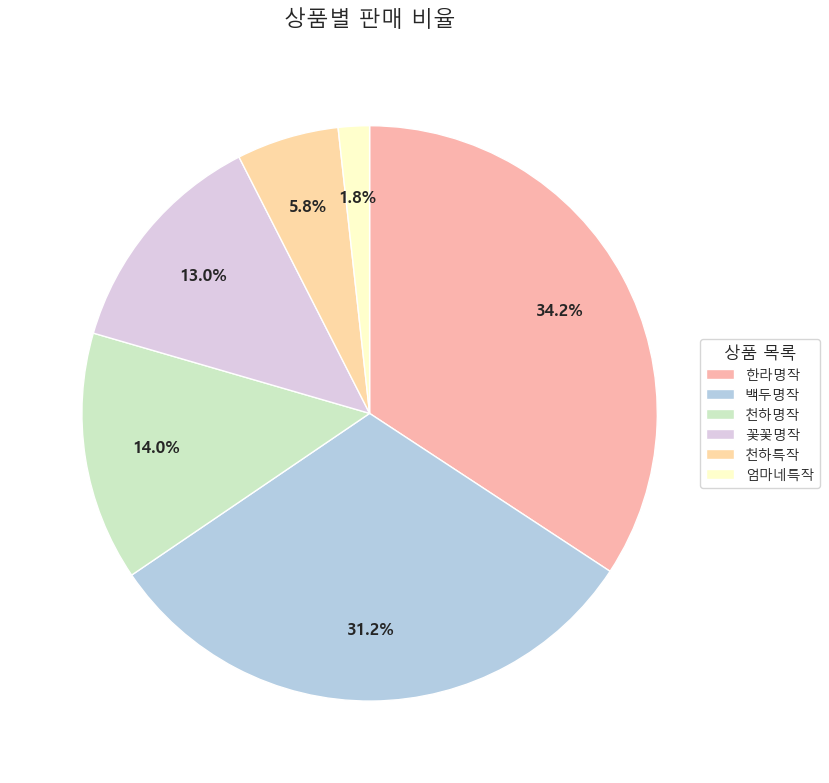

In [76]:
# 1. 상품명 빈도수 계산 
product = df_total['상품명'].value_counts()

plt.figure(figsize=(12, 8))

# 1. 파이 차트 그리기
# 'pastel1' 대신 'pastel'로 수정했습니다.
patches, texts, autotexts = plt.pie(
    x=product.values, 
    labels=None,                 
    autopct="%.1f%%",            
    startangle=90,
    colors=sns.color_palette("Pastel1"),
    pctdistance=0.75,
    counterclock=False
)

# 2. 퍼센트 글자 스타일 설정
for autotext in autotexts:    
    autotext.set_weight('bold')

# 3. 범례(Legend) 추가
plt.legend(
    patches, 
    product.index, 
    title="상품 목록",
    loc="center left",
    bbox_to_anchor=(0.95, 0.5),      
    fontsize=10
)

plt.title("상품별 판매 비율", fontsize=16, pad=20)
plt.tight_layout()  
plt.savefig('상품별 판매 비율.png', dpi=300, bbox_inches='tight')
plt.show()

# 포장 방식 별 만족도 비교 (별점 기준)

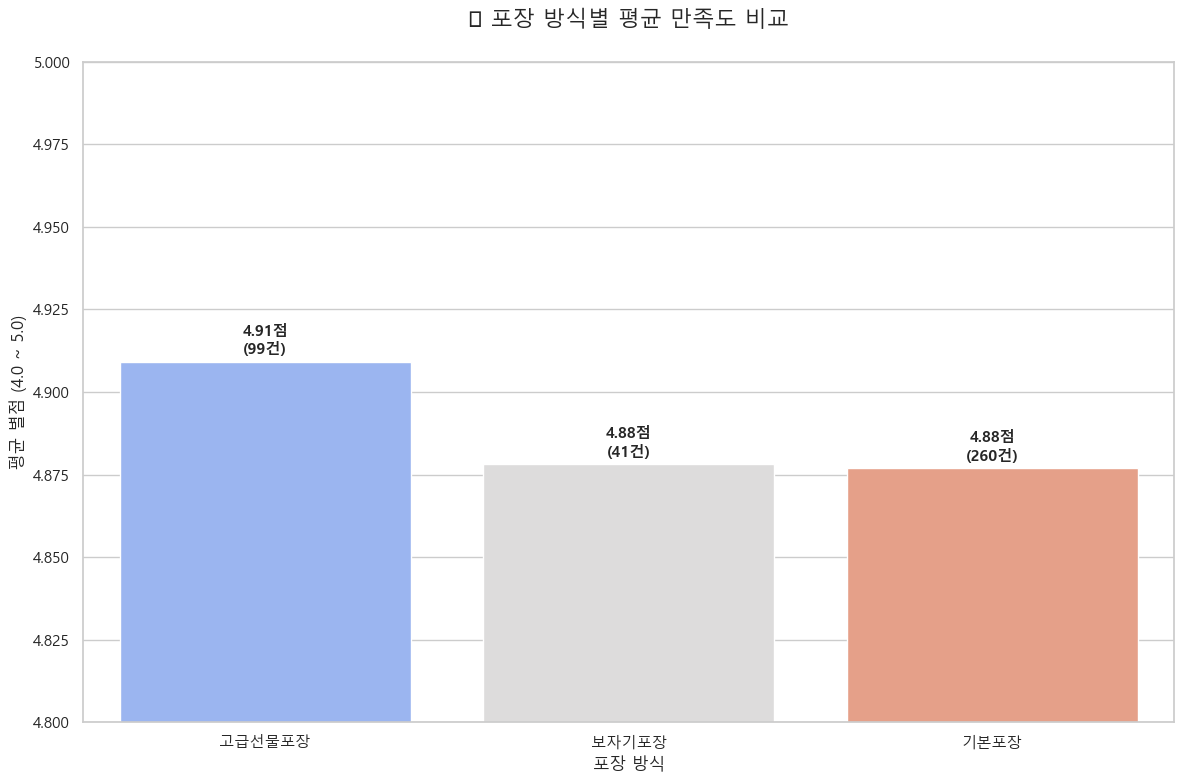

In [16]:
# 1. 포장 방식별 평균 별점과 데이터 개수 계산 (df_total 사용)
packaging_stats = df_total.groupby('포장방식')['별점'].agg(['mean', 'count']).reset_index()
packaging_stats = packaging_stats.sort_values(by='mean', ascending=False)

# 2. 그래프 스타일 설정
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", font="Malgun Gothic")

# 3. 세로 막대 그래프 그리기
# 포장 방식에 따라 색상을 다르게 주어 시각적 재미를 더합니다.
ax = sns.barplot(data=packaging_stats, x='포장방식', y='mean', palette='coolwarm')

# 4. 차이를 명확히 하기 위해 Y축 범위 설정 (4.0 ~ 5.0)
plt.ylim(4.8, 5.0)

# 5. 막대 위에 평균 점수와 리뷰 개수 표시
for p, i in zip(ax.patches, range(len(packaging_stats))):
    score = packaging_stats.iloc[i]['mean']
    count = int(packaging_stats.iloc[i]['count'])
    ax.annotate(f'{score:.2f}점\n({count}건)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 15), 
                textcoords='offset points',
                fontsize=11, fontweight='bold')

# 6. 타이틀 및 라벨 설정
plt.title('📦 포장 방식별 평균 만족도 비교', fontsize=16, pad=25)
plt.xlabel('포장 방식', fontsize=12)
plt.ylabel('평균 별점 (4.0 ~ 5.0)', fontsize=12)

plt.tight_layout()
plt.show()